# Dynamic Topic Model (DTM)

#### Author information

- **Name:** Jaeseong Choe

- **email address:** cjssoote@gmail.com

- **GitHub:** https://github.com/sorrychoe

- **Linkedin:** https://www.linkedin.com/in/jaeseong-choe-048639250/

- **Personal Webpage:** https://jaeseongchoe.vercel.app/

## Part 1. Brief background of methodology

### Overview

- **Dynamic Topic Model(DTM) extends LDA to model the evolution of topics over time**. 

- It captures **how the distribution of topics changes across time periods**.

### Situation Before DTM

- Topic models like LDA does not account for how topics may evolve over time in a corpus with chronological data.

### Why DTM Was Introduced

- DTM was introduced from the paper *"Dynamic Topic Models."* of Blei, D. M., & Lafferty, J. D. (2006).

- DTM extends LDA by incorporating time as a factor, allowing for modeling how topics change over time in sequential document collections.

### Use Cases

- DTM is used in analyzing temporal trends in topics, such as academic articles or scientific literature over the years.

## Part 2. Key concept of methodology

### Key Concept

- DTM captures topic evolution by modeling the topic distributions over time using logistic normal distribution.

### Generative Process

DTM models a collection of documents split into sequential time slices. For each time slice $t$, the generative process is as follows:

1. **Evolution of Topics**:
   - Topics $\beta_{t,k} $ evolve over time according to a state space model:
   
   $$
   \beta_{t,k} | \beta_{t-1,k} \sim \mathcal{N}(\beta_{t-1,k}, \sigma^2 I)
   $$
   
   where $\beta_{t,k} $ represents the parameters of topic $k$ at time $t$, modeled as a Gaussian distribution evolving from the previous time slice.

2. **Topic Proportions**:
   - Document-specific topic proportions $\theta_{t,d} $ (for document $d$ in time slice $t$) are drawn from a **logistic normal distribution**:
   
   $$
   \alpha_t | \alpha_{t-1} \sim \mathcal{N}(\alpha_{t-1}, \delta^2 I)
   $$

   where $\alpha_t $ is the mean of the logistic normal distribution governing the topic proportions for time $t$.

3. **Document Generation**:
   - For each word in a document, the generative process is as follows:
     - Draw a topic assignment $z$ from the document's topic proportions $\theta$.
     - Draw a word $w$ from the distribution corresponding to topic $z$:
   
   $$
   p(w | z, \beta_{t,k}) = \text{Multinomial}(\pi(\beta_{t,k}))
   $$

   The logistic mapping function $\pi(\beta)$ ensures that the multinomial distribution over words is computed from the natural parameters $\beta$.

   $\pi(\beta_{k,t})w = \frac{exp(\beta_{k,t,w})}{\Sigma_w exp(\beta_{k,t,w})}$

![DTM_Graphic](./img/DTM_Graphic.png)

### Mathematical Formulation:
- **State-Space Model**: The evolution of topics is modeled as a state-space process with Gaussian noise:
  
  $$
  \beta_{t,k} | \beta_{t-1,k} \sim \mathcal{N}(\beta_{t-1,k}, \sigma^2 I)
  $$

  This assumes each topic $\beta$ evolves smoothly over time, with deviations modeled by Gaussian noise.

- **Natural Parameterization**: The topic distributions are parameterized as:
  
  $$
  \beta_{i} = \log \left( \frac{\pi_i}{\pi_V} \right)
  $$

  where $\pi$ is the mean parameter of the multinomial distribution, and $\pi_V$ is the reference term for normalization.

- **Topic Proportion Model**: Document-specific topic proportions are drawn from a logistic normal distribution, with the mean evolving over time:
  
  $$
  \alpha_t | \alpha_{t-1} \sim \mathcal{N}(\alpha_{t-1}, \delta^2 I)
  $$

### Inference
Posterior inference in DTM is achieved using variational inference methods due to the time dependencies between topics.

- **Variational Kalman Filtering**: Kalman filtering is applied to approximate the posterior distribution over the evolving topics. Variational parameters are optimized by minimizing the Kullback-Leibler (KL) divergence from the true posterior.

  Forward-backward equations similar to Kalman filtering provide updates for the variational parameters, enabling tractable inference for sequential topic distributions.

- **Variational Wavelet Regression**: Another method for inference is wavelet regression, which smooths the evolution of topics by fitting a wavelet basis to the sequences of topics.

### Strength

- DTM reveals how topics change over time and can track evolving themes in time-sequenced data.

## Part 3. Example

### Before Sample code
- Generally, the gensim library is used for topic modeling, but tomotopy was used in this practice.
- The reason is that the library is excellent in terms of speed and is characterized by best reproduction of the mathematical formulas mentioned in the paper.
- Although it is not a library with many users yet, it is a library that is emerging as an alternative to gensim, so topic modeling was attempted through this library.

### Precautions

- If you re-execute the code, there may be a slight difference in the result.

- Of course, the difference in the number or content of the topic will not be significant due to the seed number and the learning rate, but the number of the topic changes.

In [1]:
# import librarys
import numpy as np # for data preprocessing
import pandas as pd # for load excel data
import pyBigKinds as pbk # for preprocessing news text data
import tomotopy as tp # for topic modeling
import matplotlib.pyplot as plt # for visualize the plot

# for ignore the warning message
import warnings
warnings.filterwarnings("ignore")

In [2]:
def dtmmodel(df:pd.DataFrame, k:int):
    """Define the DTM model """
    words = pbk.keyword_parser(pbk.keyword_list(df))
    t = np.max(df["시점"])+1
    model = tp.DTModel(min_cf=5, rm_top=10, t=t, k=k, seed=42)

    for i in range(len(words)):
        model.add_doc(words=words[i], timepoint=df["시점"][i])

    model.train(0)

    # print docs, vocabs and words
    print('Num docs:{}, Num Vocabs:{}, Total Words:{}'.format(
        len(model.docs), len(model.used_vocabs), model.num_words
    ))

    model.train(2000, show_progress=True)
    
    return model

In [3]:
def find_proper_k(df, start, end):
    """find proper k value for hyperparameter tunning""" 
    words = pbk.keyword_parser(pbk.keyword_list(df))
    for i in range(start,end+1):        
        # model setting
        mdl=tp.DTModel(min_cf=5, rm_top=10, k=i, t=(np.max(df["시점"])+1), seed=42)
        
        for k in range(len(words)):
            mdl.add_doc(words=words[k], timepoint=df["시점"][k])
        
        mdl.train(100)
        
        # coherence score
        print('==== Coherence : k = {} ===='.format(i))
        print("\n")
        coh = tp.coherence.Coherence(mdl, coherence="c_v")
        
        average_coh = []
        
        for j in df["시점"].unique():
            t_coh = [coh.get_score(topic_id=c, timepoint=j) for c in range(mdl.k)]
            
            print('timepoint: {}'.format(j))
            print("\n")
            print('average:{}'.format(np.mean(t_coh)))
            print("\n")
            print('Per Topic:{}'.format(t_coh))
            print("\n")
            
            average_coh.append(t_coh)
        if i == 3:
            proper_k = 3
            tmp = np.mean(average_coh)
        elif tmp < np.mean(average_coh):
            proper_k = i
            tmp = np.mean(average_coh)     

    return proper_k    

In [4]:
def dtm_plot(df):
    """preprocessing for DTM Topic data visualization"""
    f = plt.figure()
    plt.title('Changes in topic percentage by year', color='black')
    df.plot(ax=f.gca(),colormap='gnuplot')
    plt.xticks(np.array(range(1995,2024)),rotation=45)

    ax=f.gca()
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.set_ylabel('percent(%)')
    plt.show()

In [5]:
# data load
# The data is related to Handong University, 
# which was reported in major Korean daily newspapers from January 1995 to September 2024.
df = pd.read_excel("data/NewsResult_19950101-20240930.xlsx", engine="openpyxl")

# add the time stamp for DTM
df["시점"] = (round(df["일자"]/10000,0)%1995).astype(int)
df = df.sort_values("시점")
df.reset_index(drop=True, inplace=True)

#find proper k value
proper_k = find_proper_k(df, 3 ,10)

==== Coherence : k = 3 ====


timepoint: 0


average:0.837225087483724


Per Topic:[0.8520348906517029, 0.8457055509090423, 0.8139348208904267]


timepoint: 1


average:0.780074183146159


Per Topic:[0.723054301738739, 0.8779748976230621, 0.7391933500766754]


timepoint: 2


average:0.7905572851498922


Per Topic:[0.7730888068675995, 0.792112672328949, 0.806470376253128]


timepoint: 3


average:0.776647452513377


Per Topic:[0.7242663592100144, 0.8223241686820983, 0.7833518296480179]


timepoint: 4


average:0.6514309952656429


Per Topic:[0.6301523298025131, 0.657799831032753, 0.6663408249616622]


timepoint: 5


average:0.6919246256351471


Per Topic:[0.6710481524467469, 0.7228137731552124, 0.681911951303482]


timepoint: 6


average:0.7311944276094436


Per Topic:[0.6936022132635117, 0.7958781480789184, 0.7041029214859009]


timepoint: 7


average:0.7826703091462454


Per Topic:[0.6902486622333527, 0.7824620604515076, 0.8753002047538757]


timepoint: 8


average:0.6971695959568024


In [6]:
# Model setting with K
mdl = dtmmodel(df, proper_k)

Num docs:8051, Num Vocabs:27099, Total Words:1657565


Iteration: 100%|███████████| 2000/2000 [03:24<00:00,  9.79it/s, LLPW: -8.626212]


In [7]:
# get summary
mdl.summary()

<Basic Info>
| DTModel (current version: 0.12.7)
| 8051 docs, 1657565 words
| Total Vocabs: 128176, Used Vocabs: 27099
| Entropy of words: 8.65140
| Entropy of term-weighted words: 8.65140
| Removed Vocabs: 미국 대학 북한 교수 한동대 한국 대통령 정부 교육 중국
|
<Training Info>
| Iterations: 2000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -8.62655
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 5 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 10 (the number of top words to be removed)
| k: 3 (the number of topics between 1 ~ 32767)
| t: 30 (the number of timpoints)
| alpha_var: 0.1 (transition variance of alpha (per-document topic distribution))
| eta_var: 0.1 (variance of eta (topic distribution of each document) from its alpha )
| phi_var: 0.1 (transition variance of phi (word distribution of each topic))
| lr_a: 0.01 (shape parameter `a` greater than zero, for SGLD step size calculated as `e_i = a * (b + i) ^ (-c)`)


## Why don't the topics appear evenly?

- Looking at the results of the summary at the top, it is found that in some topics, the subject changes rapidly over time. This is a disadvantage of DTM, and in the case of data with fast generation and destruction of topics, such as news articles, the performance of DTM deteriorates. The reason is that DTM presupposes that the topics resulting from the topic modeling are maintained. 

- Due to this, the performance of DTM tends to decrease in areas where trends change rapidly. Therefore, DTM is suitable for tracking changes in existing topics, but the ToT model is more suitable than DTM for data where topics are frequently created and extinguished.

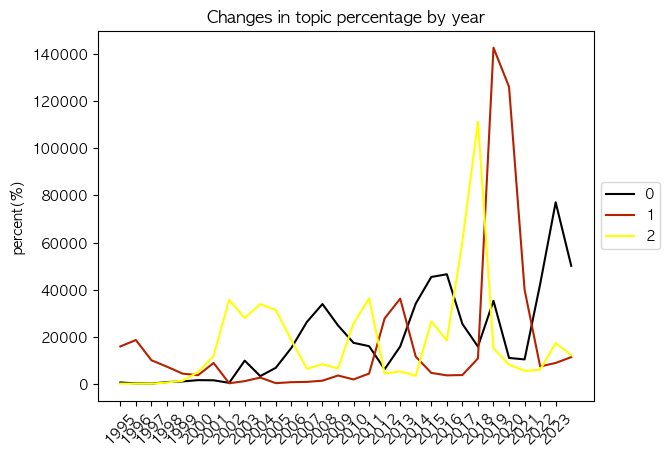

In [8]:
# get dtm dataframe
dtm_df = pd.DataFrame(mdl.get_count_by_topics())
dtm_df.index = df["시점"].unique() + 1995

# show result as a plot
dtm_plot(dtm_df)

# result interpretation
- As can be seen from the change in the topic ratio by year, it can be seen that articles on Handong Global University are increasing over time.

- In particular, it is confirmed that the frequency of specific topics is increasing further.